# SUPER-RESOLUTION GAN
#### ALL CODES ARE FROM [SREZ](https://github.com/david-gpu/srez). 

In [1]:
import imageio
imageio.plugins.ffmpeg.download()
import os
import argparse
import random
import time
import numpy as np
import numpy.random
import scipy.misc 
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import tensorflow as tf
from model import Model
%matplotlib inline  
print ("PACKAGES LOADED.")

PACKAGES LOADED.


# CONFIGURATION

In [2]:
# RESET EXISTING FLAG 
tf.app.flags.FLAGS = tf.python.platform.flags._FlagValues()
tf.app.flags._global_parser = argparse.ArgumentParser()
# SET FLAGS
tf.app.flags.DEFINE_integer('batch_size', 16,
                            "Number of samples per batch.")
tf.app.flags.DEFINE_string('checkpoint_dir', 'checkpoint',
                           "Output folder where checkpoints are dumped.")
tf.app.flags.DEFINE_integer('checkpoint_period', 10000,
                            "Number of batches in between checkpoints")
tf.app.flags.DEFINE_string('dataset', 'dataset',
                           "Path to the dataset directory.")
tf.app.flags.DEFINE_float('epsilon', 1e-8,
                          "Fuzz term to avoid numerical instability")
tf.app.flags.DEFINE_string('run', 'demo',
                            "Which operation to run. [demo|train]")
tf.app.flags.DEFINE_float('gene_l1_factor', 0.8,
                          "Multiplier for generator L1 loss term")
tf.app.flags.DEFINE_float('learning_beta1', 0.5,
                          "Beta1 parameter used for AdamOptimizer")
tf.app.flags.DEFINE_float('learning_rate_start', 0.00020,
                          "Starting learning rate used for AdamOptimizer")
tf.app.flags.DEFINE_integer('learning_rate_half_life', 5000,
                            "Number of batches until learning rate is halved")
tf.app.flags.DEFINE_bool('log_device_placement', False,
                         "Log the device where variables are placed.")
tf.app.flags.DEFINE_integer('sample_size', 64,
                            "Image sample size in pixels. Range [64,128]")
tf.app.flags.DEFINE_integer('summary_period', 4000, # 10,000
                            "Number of batches between summary data dumps")
tf.app.flags.DEFINE_integer('random_seed', 0,
                            "Seed used to initialize rng.")
tf.app.flags.DEFINE_integer('test_vectors', 16,
                            """Number of features to use for testing""")
tf.app.flags.DEFINE_string('train_dir', 'train',
                           "Output folder where training logs are dumped.")
tf.app.flags.DEFINE_integer('train_time', 30,
                            "Time in minutes to train the model")
tf.app.flags.DEFINE_integer('max_batch', 20000,
                            "Maximum number of batch iterations")
FLAGS = tf.app.flags.FLAGS

# SETUP TENSORFLOW

In [3]:
def setup_tensorflow():
    # Create session
    config = tf.ConfigProto(log_device_placement=FLAGS.log_device_placement)
    sess = tf.Session(config=config)
    # Initialize rng with a deterministic seed
    with sess.graph.as_default():
        tf.set_random_seed(FLAGS.random_seed)
    random.seed(FLAGS.random_seed)
    np.random.seed(FLAGS.random_seed)
    summary_writer = tf.summary.FileWriter(FLAGS.train_dir, sess.graph)
    return sess, summary_writer

In [4]:
sess, summary_writer = setup_tensorflow()
print ("SETUP TF SESSION AND SUMMARY")

SETUP TF SESSION AND SUMMARY


# PREPARE DIRECTORIES

In [5]:
def prepare_dirs(delete_train_dir=False):
    # CREATE CHECKPOINT DIRECTORIES
    if not tf.gfile.Exists(FLAGS.checkpoint_dir):
        tf.gfile.MakeDirs(FLAGS.checkpoint_dir)
        print ("CREATE CHECKPOINT FOLDER[%s]" % (FLAGS.checkpoint_dir))
    else:
        print ("CHECKPOINT FOLDER[%s] ALREADY EXISTS" % (FLAGS.checkpoint_dir))
    # CLEANUP TRAIN DIR
    if delete_train_dir:
        if tf.gfile.Exists(FLAGS.train_dir):
            tf.gfile.DeleteRecursively(FLAGS.train_dir)
            print ("DELETE EVERY FILES IN TRAIN FOLDER[%s]" % (FLAGS.train_dir))
        tf.gfile.MakeDirs(FLAGS.train_dir)
        print ("CREATE TRAIN FOLDER[%s]" % (FLAGS.train_dir))
        
    # Return names of training files
    if not tf.gfile.Exists(FLAGS.dataset) or \
        not tf.gfile.IsDirectory(FLAGS.dataset):
        print ("DATASET FOLDER[%s] DOES NOT EXIST" % (FLAGS.dataset))
        return
    else:
        print ("DATASET FOLDER[%s] EXISTS" % (FLAGS.dataset))
    # LOAD FILES IN THE DATASET FOLDER
    filenames = tf.gfile.ListDirectory(FLAGS.dataset)
    filenames = sorted(filenames)
    random.shuffle(filenames)
    filenames = [os.path.join(FLAGS.dataset, f) \
                 for f in filenames if os.path.splitext(f)[1] == '.jpg']
    return filenames

In [6]:
all_filenames = prepare_dirs(delete_train_dir=True)
print ("[%d] IMAGES LOADED." % (len(all_filenames)))

CHECKPOINT FOLDER[checkpoint] ALREADY EXISTS
DELETE EVERY FILES IN TRAIN FOLDER[train]
CREATE TRAIN FOLDER[train]
DATASET FOLDER[dataset] EXISTS
[202599] IMAGES LOADED.


# SEPARATE TRAINING AND TEST SETS

In [7]:
train_filenames = all_filenames[:-FLAGS.test_vectors]
test_filenames  = all_filenames[-FLAGS.test_vectors:]
print ("[%d] TRAIN IMAGES" % (len(train_filenames)))
print ("[%d] TEST IMAGES" % (len(test_filenames)))

[202583] TRAIN IMAGES
[16] TEST IMAGES


# SETUP INPUTS

In [8]:
def setup_inputs(sess, filenames, image_size=None, capacity_factor=3):
    if image_size is None:
        image_size = FLAGS.sample_size
    # READ JPEG IMAGES
    reader = tf.WholeFileReader()
    filename_queue = tf.train.string_input_producer(filenames)
    key, value = reader.read(filename_queue)
    channels = 3
    image = tf.image.decode_jpeg(value, channels=channels, name="dataset_image")
    image.set_shape([None, None, channels])
    # RANDOM AUGMENTATIONS
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, .95, 1.05)
    image = tf.image.random_brightness(image, .05)
    image = tf.image.random_contrast(image, .95, 1.05)
    # RANDOM CROP
    wiggle = 8
    off_x, off_y = 25-wiggle, 60-wiggle
    crop_size = 128
    crop_size_plus = crop_size + 2*wiggle
    image = tf.image.crop_to_bounding_box(image, off_y, off_x, crop_size_plus, crop_size_plus)
    image = tf.random_crop(image, [crop_size, crop_size, 3])
    image = tf.reshape(image, [1, crop_size, crop_size, 3])
    image = tf.cast(image, tf.float32)/255.0
    if crop_size != image_size:
        image = tf.image.resize_area(image, [image_size, image_size])

    # THE INPUT IS SIMPLY A K-DOWNSCALED VERSION
    K = 4
    downsampled = tf.image.resize_area(image, [image_size//K, image_size//K])
    feature = tf.reshape(downsampled, [image_size//K, image_size//K, 3])
    label   = tf.reshape(image,       [image_size,   image_size,     3])
    # USE ASYNCHRONOUS QUEUES 
    features, labels = tf.train.batch([feature, label],
                                      batch_size=FLAGS.batch_size,
                                      num_threads=4,
                                      capacity = capacity_factor*FLAGS.batch_size,
                                      name='labels_and_features')
    tf.train.start_queue_runners(sess=sess)
    return features, labels

In [9]:
train_features, train_labels = setup_inputs(sess, train_filenames)
test_features,  test_labels  = setup_inputs(sess, test_filenames)
print ("BATCH SIZE IS [%d]"     % (FLAGS.batch_size))
print ("train_features is [%s]" % (train_features))
print ("train_labels is [%s]"   % (train_labels)) 
print ("test_features is [%s]"  % (test_features)) 
print ("test_labels is [%s]"    % (test_labels)) 

BATCH SIZE IS [16]
train_features is [Tensor("labels_and_features:0", shape=(16, 16, 16, 3), dtype=float32)]
train_labels is [Tensor("labels_and_features:1", shape=(16, 64, 64, 3), dtype=float32)]
test_features is [Tensor("labels_and_features_1:0", shape=(16, 16, 16, 3), dtype=float32)]
test_labels is [Tensor("labels_and_features_1:1", shape=(16, 64, 64, 3), dtype=float32)]


# ADDING NOISE TO TRAIN FEATURES

In [10]:
noise_level = .03
noisy_train_features = train_features + \
    tf.random_normal(train_features.get_shape(), stddev=noise_level)

# MODEL CLASS

#### MOVED TO 'MODEL.PY'

# GENERATOR

In [11]:
def _generator_model(sess, features, labels, channels):
    # Upside-down all-convolutional resnet
    mapsize = 3
    res_units  = [256, 128, 96]
    old_vars = tf.global_variables()
    # See Arxiv 1603.05027
    model = Model('GEN', features)
    for ru in range(len(res_units)-1):
        nunits  = res_units[ru]
        for j in range(2):
            model.add_residual_block(nunits, mapsize=mapsize)
        # Spatial upscale (see http://distill.pub/2016/deconv-checkerboard/)
        # and transposed convolution
        model.add_upscale()
        model.add_batch_norm()
        model.add_relu()
        model.add_conv2d_transpose(nunits, mapsize=mapsize, stride=1, stddev_factor=1.)
    # Finalization a la "all convolutional net"
    nunits = res_units[-1]
    model.add_conv2d(nunits, mapsize=mapsize, stride=1, stddev_factor=2.)
    # Worse: model.add_batch_norm()
    model.add_relu()
    model.add_conv2d(nunits, mapsize=1, stride=1, stddev_factor=2.)
    # Worse: model.add_batch_norm()
    model.add_relu()
    # Last layer is sigmoid with no batch normalization
    model.add_conv2d(channels, mapsize=1, stride=1, stddev_factor=1.)
    model.add_sigmoid()
    new_vars  = tf.global_variables()
    gene_vars = list(set(new_vars) - set(old_vars))
    return model.get_output(), gene_vars

print ("GENERATOR READY")

GENERATOR READY


# DISCRIMINATOR

In [12]:
def _discriminator_model(sess, features, disc_input):
    # Fully convolutional model
    mapsize = 3
    layers  = [64, 128, 256, 512]
    old_vars = tf.global_variables()
    model = Model('DIS', 2*disc_input - 1)
    for layer in range(len(layers)):
        nunits = layers[layer]
        stddev_factor = 2.0
        model.add_conv2d(nunits, mapsize=mapsize, stride=2, stddev_factor=stddev_factor)
        model.add_batch_norm()
        model.add_relu()
    # Finalization a la "all convolutional net"
    model.add_conv2d(nunits, mapsize=mapsize, stride=1, stddev_factor=stddev_factor)
    model.add_batch_norm()
    model.add_relu()
    model.add_conv2d(nunits, mapsize=1, stride=1, stddev_factor=stddev_factor)
    model.add_batch_norm()
    model.add_relu()
    # Linearly map to real/fake and return average score
    # (softmax will be applied later)
    model.add_conv2d(1, mapsize=1, stride=1, stddev_factor=stddev_factor)
    model.add_mean()
    new_vars  = tf.global_variables()
    disc_vars = list(set(new_vars) - set(old_vars))
    return model.get_output(), disc_vars

print ("DISCRIMINATOR READY")

DISCRIMINATOR READY


# CREATE SR-GAN MODEL

In [13]:
def create_model(sess, features, labels):
    # Generator
    rows      = int(features.get_shape()[1])
    cols      = int(features.get_shape()[2])
    channels  = int(features.get_shape()[3])
    gene_minput = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, rows, cols, channels])
    
    # TBD: Is there a better way to instance the generator?
    with tf.variable_scope('gene') as scope:
        gene_output, gene_var_list = \
                    _generator_model(sess, features, labels, channels)
        scope.reuse_variables()
        gene_moutput, _ = _generator_model(sess, gene_minput, labels, channels)
    # Discriminator with real data
    disc_real_input = tf.identity(labels, name='disc_real_input')
    # TBD: Is there a better way to instance the discriminator?
    with tf.variable_scope('disc') as scope:
        disc_real_output, disc_var_list = \
                _discriminator_model(sess, features, disc_real_input)
        scope.reuse_variables()
        disc_fake_output, _ = _discriminator_model(sess, features, gene_output)
    return [gene_minput,      gene_moutput,
            gene_output,      gene_var_list,
            disc_real_output, disc_fake_output, disc_var_list]

In [14]:
[gene_minput, gene_moutput, gene_output, gene_var_list,
    disc_real_output, disc_fake_output, disc_var_list] \
    = create_model(sess, noisy_train_features, train_labels) 

# GENERATOR LOSS

In [15]:
def _downscale(images, K):
    """Differentiable image downscaling by a factor of K"""
    arr = np.zeros([K, K, 3, 3])
    arr[:,:,0,0] = 1.0/(K*K)
    arr[:,:,1,1] = 1.0/(K*K)
    arr[:,:,2,2] = 1.0/(K*K)
    dowscale_weight = tf.constant(arr, dtype=tf.float32)    
    downscaled = tf.nn.conv2d(images, dowscale_weight,
                              strides=[1, K, K, 1],
                              padding='SAME')
    return downscaled

def create_generator_loss(disc_output, gene_output, features):
    # I.e. did we fool the discriminator?
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(disc_output, tf.ones_like(disc_output))
    gene_ce_loss  = tf.reduce_mean(cross_entropy, name='gene_ce_loss')
    # I.e. does the result look like the feature?
    K = int(gene_output.get_shape()[1])//int(features.get_shape()[1])
    assert K == 2 or K == 4 or K == 8    
    downscaled = _downscale(gene_output, K)
    gene_l1_loss  = tf.reduce_mean(tf.abs(downscaled - features), name='gene_l1_loss')
    gene_loss     = tf.add((1.0 - FLAGS.gene_l1_factor) * gene_ce_loss,
                           FLAGS.gene_l1_factor * gene_l1_loss, name='gene_loss')
    return gene_loss

In [16]:
gene_loss = create_generator_loss(disc_fake_output, gene_output, train_features)

# DISCRIMINATOR LOSS

In [17]:
def create_discriminator_loss(disc_real_output, disc_fake_output):
    # I.e. did we correctly identify the input as real or not?
    cross_entropy_real = tf.nn.sigmoid_cross_entropy_with_logits(disc_real_output, tf.ones_like(disc_real_output))
    disc_real_loss     = tf.reduce_mean(cross_entropy_real, name='disc_real_loss')
    cross_entropy_fake = tf.nn.sigmoid_cross_entropy_with_logits(disc_fake_output, tf.zeros_like(disc_fake_output))
    disc_fake_loss     = tf.reduce_mean(cross_entropy_fake, name='disc_fake_loss')
    return disc_real_loss, disc_fake_loss

In [18]:
disc_real_loss, disc_fake_loss = \
    create_discriminator_loss(disc_real_output, disc_fake_output)
disc_loss = tf.add(disc_real_loss, disc_fake_loss, name='disc_loss')

# OPTIMIZER

In [19]:
def create_optimizers(gene_loss, gene_var_list,
                      disc_loss, disc_var_list):    
    global_step    = tf.Variable(0, dtype=tf.int64,   trainable=False, name='global_step')
    learning_rate  = tf.placeholder(dtype=tf.float32, name='learning_rate')
    gene_opti = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                       beta1=FLAGS.learning_beta1,
                                       name='gene_optimizer')
    disc_opti = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                       beta1=FLAGS.learning_beta1,
                                       name='disc_optimizer')
    gene_minimize = gene_opti.minimize(gene_loss, var_list=gene_var_list
                                       , name='gene_loss_minimize', global_step=global_step)
    disc_minimize = disc_opti.minimize(disc_loss, var_list=disc_var_list
                                       , name='disc_loss_minimize', global_step=global_step)
    return (global_step, learning_rate, gene_minimize, disc_minimize)

In [20]:
(global_step, learning_rate, gene_minimize, disc_minimize) = \
    create_optimizers(gene_loss, gene_var_list, disc_loss, disc_var_list)

# TRAIN

In [21]:
class TrainData(object):
    def __init__(self, dictionary):
        self.__dict__.update(dictionary)
train_data = TrainData(locals())

In [22]:
def _summarize_progress(train_data, feature, label, gene_output, batch, suffix, max_samples=4):
    td = train_data
    size = [label.shape[1], label.shape[2]]
    nearest = tf.image.resize_nearest_neighbor(feature, size)
    nearest = tf.maximum(tf.minimum(nearest, 1.0), 0.0)
    bicubic = tf.image.resize_bicubic(feature, size)
    bicubic = tf.maximum(tf.minimum(bicubic, 1.0), 0.0)
    clipped = tf.maximum(tf.minimum(gene_output, 1.0), 0.0)
    image   = tf.concat(2, [nearest, bicubic, clipped, label])

    image = image[0:max_samples,:,:,:]
    image = tf.concat(0, [image[i,:,:,:] for i in range(max_samples)])
    image = td.sess.run(image)

    _filename = 'batch%06d_%s.png' % (batch, suffix)
    filename = os.path.join(FLAGS.train_dir, _filename)
    scipy.misc.toimage(image, cmin=0., cmax=1.).save(filename)
    print("    Saved %s" % (filename,))
    # ADDITIONAL PLOT
    currsampleimg = imread(filename)
    plt.figure(figsize=(5, 5))
    plt.imshow(currsampleimg)
    plt.title(_filename)
    plt.show()
    
def _save_checkpoint(train_data, batch):
    td = train_data
    oldname = 'checkpoint_old.txt'
    newname = 'checkpoint_new.txt'
    oldname = os.path.join(FLAGS.checkpoint_dir, oldname)
    newname = os.path.join(FLAGS.checkpoint_dir, newname)
    # Delete oldest checkpoint
    try:
        tf.gfile.Remove(oldname)
        tf.gfile.Remove(oldname + '.meta')
    except:
        pass
    # Rename old checkpoint
    try:
        tf.gfile.Rename(newname, oldname)
        tf.gfile.Rename(newname + '.meta', oldname + '.meta')
    except:
        pass
    # GENERATE NEW CHECKPOINT
    saver = tf.train.Saver()
    saver.save(td.sess, newname)
    print("    Checkpoint saved")

In [23]:
def train_model(train_data):
    td = train_data
    summaries = tf.summary.merge_all()
    td.sess.run(tf.global_variables_initializer())
    lrval       = FLAGS.learning_rate_start
    start_time  = time.time()
    done  = False
    batch = 0
    assert FLAGS.learning_rate_half_life % 10 == 0
    # CACHE TEST DATA
    test_feature, test_label = td.sess.run([td.test_features, td.test_labels])

    while not done:
        batch += 1
        gene_loss = disc_real_loss = disc_fake_loss = -1.234
        feed_dict = {td.learning_rate : lrval}
        ops = [td.gene_minimize, td.disc_minimize, td.gene_loss, td.disc_real_loss, td.disc_fake_loss]
        _, _, gene_loss, disc_real_loss, disc_fake_loss = td.sess.run(ops, feed_dict=feed_dict)

        if batch % 200 == 0:
            elapsed = int(time.time() - start_time)/60
            print('Progress[%3d%%], Batch [%05d/%05d], G_Loss[%3.3f], \
                    D_Real_Loss[%3.3f], D_Fake_Loss[%3.3f]' %
                  (int(100*elapsed/FLAGS.train_time), batch, FLAGS.max_batch
                   , gene_loss, disc_real_loss, disc_fake_loss))
            # TERMINATE CONDITION 
            # current_progress = elapsed / FLAGS.train_time # USE TIME
            current_progress = batch / FLAGS.max_batch # USE BATCH
            if current_progress >= 1.0:
                done = True 
            # LEARNING RATE SCHEDULE
            if batch % FLAGS.learning_rate_half_life == 0:
                lrval *= .5

        if batch % FLAGS.summary_period == 0 or batch == 1:
            # SHOW PROGRESS + PLOT GENERATED SR
            feed_dict = {td.gene_minput: test_feature}
            gene_output = td.sess.run(td.gene_moutput, feed_dict=feed_dict)
            _summarize_progress(td, test_feature, test_label, gene_output, batch, 'out')
            
        if batch % FLAGS.checkpoint_period == 0:
            # SAVE CHECK POINT
            _save_checkpoint(td, batch)
    # SAVE CHECK POINT
    _save_checkpoint(td, batch)
    print('Finished training!')

# TRAIN SR-GAN

    Saved train/batch000001_out.png


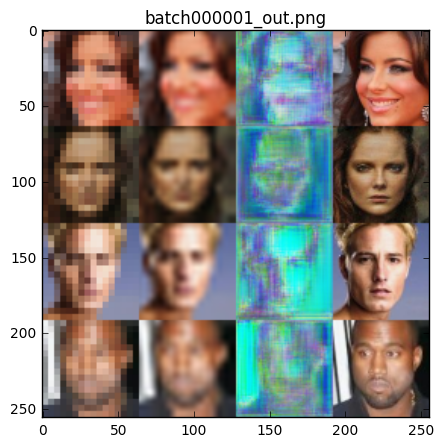

Progress[  0%], Batch [00200/20000], G_Loss[0.197], D_Real_Loss[0.661], D_Fake_Loss[0.641]
Progress[  0%], Batch [00400/20000], G_Loss[0.227], D_Real_Loss[0.684], D_Fake_Loss[0.521]
Progress[  0%], Batch [00600/20000], G_Loss[0.208], D_Real_Loss[0.479], D_Fake_Loss[0.651]
Progress[  3%], Batch [00800/20000], G_Loss[0.204], D_Real_Loss[0.707], D_Fake_Loss[0.666]
Progress[  3%], Batch [01000/20000], G_Loss[0.219], D_Real_Loss[0.721], D_Fake_Loss[0.550]
Progress[  3%], Batch [01200/20000], G_Loss[0.160], D_Real_Loss[0.564], D_Fake_Loss[0.851]
Progress[  6%], Batch [01400/20000], G_Loss[0.155], D_Real_Loss[0.487], D_Fake_Loss[0.839]
Progress[  6%], Batch [01600/20000], G_Loss[0.216], D_Real_Loss[0.731], D_Fake_Loss[0.543]
Progress[  6%], Batch [01800/20000], G_Loss[0.228], D_Real_Loss[0.622], D_Fake_Loss[0.509]
Progress[ 10%], Batch [02000/20000], G_Loss[0.166], D_Real_Loss[0.487], D_Fake_Loss[0.825]
Progress[ 10%], Batch [02200/20000], G_Loss[0.229], D_Real_Loss[0.727], D_Fake_Loss[0.499]

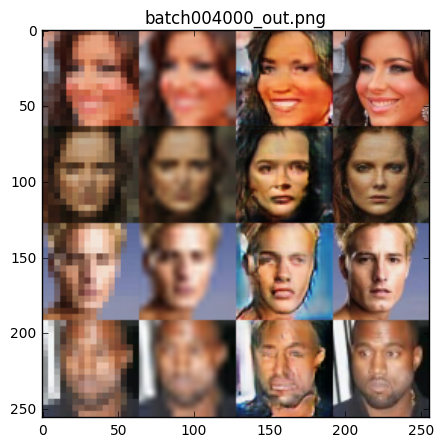

Progress[ 20%], Batch [04200/20000], G_Loss[0.251], D_Real_Loss[0.697], D_Fake_Loss[0.458]
Progress[ 20%], Batch [04400/20000], G_Loss[0.284], D_Real_Loss[0.462], D_Fake_Loss[0.399]
Progress[ 20%], Batch [04600/20000], G_Loss[0.258], D_Real_Loss[0.696], D_Fake_Loss[0.449]
Progress[ 23%], Batch [04800/20000], G_Loss[0.220], D_Real_Loss[0.314], D_Fake_Loss[0.626]
Progress[ 23%], Batch [05000/20000], G_Loss[0.358], D_Real_Loss[0.536], D_Fake_Loss[0.253]
Progress[ 23%], Batch [05200/20000], G_Loss[0.236], D_Real_Loss[0.478], D_Fake_Loss[0.490]
Progress[ 26%], Batch [05400/20000], G_Loss[0.240], D_Real_Loss[0.764], D_Fake_Loss[0.504]
Progress[ 26%], Batch [05600/20000], G_Loss[0.254], D_Real_Loss[0.833], D_Fake_Loss[0.496]
Progress[ 26%], Batch [05800/20000], G_Loss[0.240], D_Real_Loss[0.396], D_Fake_Loss[0.500]
Progress[ 30%], Batch [06000/20000], G_Loss[0.246], D_Real_Loss[0.586], D_Fake_Loss[0.478]
Progress[ 30%], Batch [06200/20000], G_Loss[0.119], D_Real_Loss[0.210], D_Fake_Loss[1.309]

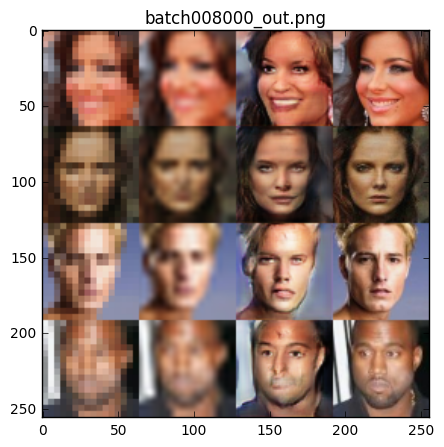

Progress[ 40%], Batch [08200/20000], G_Loss[0.177], D_Real_Loss[0.255], D_Fake_Loss[0.782]
Progress[ 40%], Batch [08400/20000], G_Loss[0.333], D_Real_Loss[0.686], D_Fake_Loss[0.285]
Progress[ 40%], Batch [08600/20000], G_Loss[0.158], D_Real_Loss[0.179], D_Fake_Loss[0.847]
Progress[ 43%], Batch [08800/20000], G_Loss[0.255], D_Real_Loss[0.209], D_Fake_Loss[0.462]
Progress[ 43%], Batch [09000/20000], G_Loss[0.461], D_Real_Loss[0.815], D_Fake_Loss[0.145]
Progress[ 43%], Batch [09200/20000], G_Loss[0.222], D_Real_Loss[0.182], D_Fake_Loss[0.556]
Progress[ 46%], Batch [09400/20000], G_Loss[0.203], D_Real_Loss[0.794], D_Fake_Loss[0.690]
Progress[ 46%], Batch [09600/20000], G_Loss[0.297], D_Real_Loss[0.264], D_Fake_Loss[0.433]
Progress[ 46%], Batch [09800/20000], G_Loss[0.214], D_Real_Loss[0.583], D_Fake_Loss[0.583]
Progress[ 50%], Batch [10000/20000], G_Loss[0.342], D_Real_Loss[0.416], D_Fake_Loss[0.268]
    Checkpoint saved
Progress[ 50%], Batch [10200/20000], G_Loss[0.203], D_Real_Loss[0.542

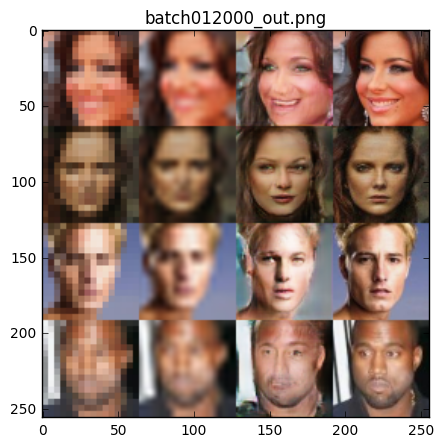

Progress[ 60%], Batch [12200/20000], G_Loss[0.304], D_Real_Loss[0.658], D_Fake_Loss[0.334]
Progress[ 60%], Batch [12400/20000], G_Loss[0.274], D_Real_Loss[0.701], D_Fake_Loss[0.412]
Progress[ 63%], Batch [12600/20000], G_Loss[0.307], D_Real_Loss[0.553], D_Fake_Loss[0.305]
Progress[ 63%], Batch [12800/20000], G_Loss[0.190], D_Real_Loss[0.344], D_Fake_Loss[0.710]
Progress[ 63%], Batch [13000/20000], G_Loss[0.274], D_Real_Loss[0.183], D_Fake_Loss[0.406]
Progress[ 63%], Batch [13200/20000], G_Loss[0.274], D_Real_Loss[0.204], D_Fake_Loss[0.419]
Progress[ 66%], Batch [13400/20000], G_Loss[0.530], D_Real_Loss[0.670], D_Fake_Loss[0.102]
Progress[ 66%], Batch [13600/20000], G_Loss[0.341], D_Real_Loss[0.384], D_Fake_Loss[0.279]
Progress[ 66%], Batch [13800/20000], G_Loss[0.326], D_Real_Loss[0.515], D_Fake_Loss[0.290]
Progress[ 70%], Batch [14000/20000], G_Loss[0.525], D_Real_Loss[0.278], D_Fake_Loss[0.113]
Progress[ 70%], Batch [14200/20000], G_Loss[0.431], D_Real_Loss[1.397], D_Fake_Loss[0.162]

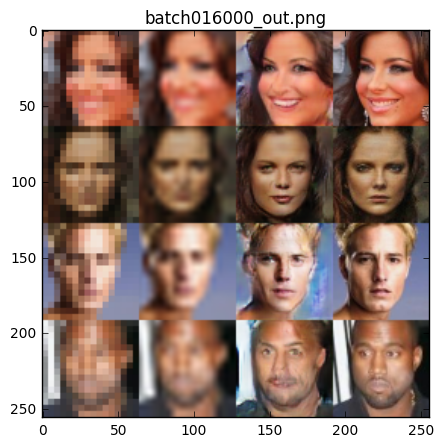

Progress[ 80%], Batch [16200/20000], G_Loss[0.325], D_Real_Loss[0.208], D_Fake_Loss[0.320]
Progress[ 80%], Batch [16400/20000], G_Loss[0.284], D_Real_Loss[0.360], D_Fake_Loss[0.387]
Progress[ 83%], Batch [16600/20000], G_Loss[0.302], D_Real_Loss[0.221], D_Fake_Loss[0.370]
Progress[ 83%], Batch [16800/20000], G_Loss[0.278], D_Real_Loss[0.396], D_Fake_Loss[0.396]
Progress[ 83%], Batch [17000/20000], G_Loss[0.290], D_Real_Loss[0.814], D_Fake_Loss[0.394]
Progress[ 86%], Batch [17200/20000], G_Loss[0.520], D_Real_Loss[1.154], D_Fake_Loss[0.116]
Progress[ 86%], Batch [17400/20000], G_Loss[0.292], D_Real_Loss[0.351], D_Fake_Loss[0.385]
Progress[ 86%], Batch [17600/20000], G_Loss[0.485], D_Real_Loss[0.668], D_Fake_Loss[0.133]
Progress[ 86%], Batch [17800/20000], G_Loss[0.346], D_Real_Loss[0.413], D_Fake_Loss[0.269]
Progress[ 90%], Batch [18000/20000], G_Loss[0.327], D_Real_Loss[0.321], D_Fake_Loss[0.304]
Progress[ 90%], Batch [18200/20000], G_Loss[0.388], D_Real_Loss[0.155], D_Fake_Loss[0.216]

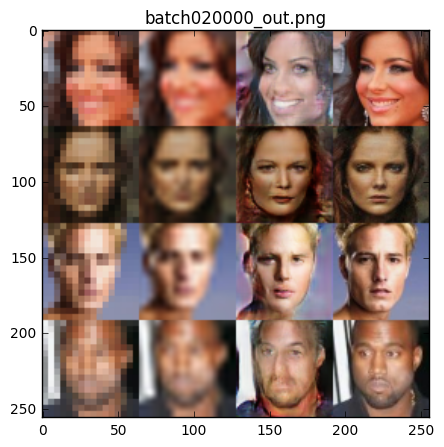

    Checkpoint saved
    Checkpoint saved
Finished training!
TRAINING DONE.


In [24]:
train_model(train_data)
print ("TRAINING DONE.")